In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

import os
import pickle
import random
import sys

from scipy.stats import ttest_ind
from torkin import TorKin

plt.rcParams['font.size'] = 18
plt.rc('font', size=18)
plt.rc('legend', fontsize=14)

In [2]:
root_dir = "/home/arash/catkin_ws/src/feedback_controller/fbc/neural_network/results/"
model_params_list = [11.541, 25.301] #5.381, 7.541, ]

kin = TorKin()

No data file named /home/erhan/catkin_ws/src/erhtor_work/tormain/Resources/larm60.txt
bodypart structure for larm is constructed.
No data file named /home/erhan/catkin_ws/src/erhtor_work/tormain/Resources/rarm60.txt
bodypart structure for rarm is constructed.
bodypart structure for head is constructed.


### Example

In [3]:
file_root_dir = root_dir +\
    "trajs:2000_blocks:3_random_11.541K/ep:1000/on_v_custl_mse_1e-05_True"

file_path = os.path.join(file_root_dir, "perf.csv")
df = pd.read_csv(file_path)  

In [4]:
df.head()

,eps_num,dnfc_succ,basel_succ,dnfc_dtw,basel_dtw,dnfc_norm,basel_norm
0,0,1.00,1.0,11.747621,14.659081,0.009798,0.012226
1,0,1.00,1.0,11.270571,11.018924,0.009400,0.009190
2,0,0.25,1.0,82.141755,17.256048,0.068509,0.014392
3,0,1.00,1.0,12.325856,14.444477,0.010280,0.012047
4,0,0.50,1.0,58.533713,13.010430,0.048819,0.010851


In [5]:
df.loc[3, 'dnfc_dtw']

12.325856041607455

In [6]:
df['dnfc_succ'] *= 100.0
df['basel_succ'] *= 100.0
df.head()

,eps_num,dnfc_succ,basel_succ,dnfc_dtw,basel_dtw,dnfc_norm,basel_norm
0,0,100.0,100.0,11.747621,14.659081,0.009798,0.012226
1,0,100.0,100.0,11.270571,11.018924,0.009400,0.009190
2,0,25.0,100.0,82.141755,17.256048,0.068509,0.014392
3,0,100.0,100.0,12.325856,14.444477,0.010280,0.012047
4,0,50.0,100.0,58.533713,13.010430,0.048819,0.010851


In [7]:
df['train_round'] = df.groupby('eps_num').cumcount() + 1
df.head(10)

,eps_num,dnfc_succ,basel_succ,dnfc_dtw,basel_dtw,dnfc_norm,basel_norm,train_round
0,0,100.0,100.0,11.747621,14.659081,0.009798,0.012226,1
1,0,100.0,100.0,11.270571,11.018924,0.009400,0.009190,2
2,0,25.0,100.0,82.141755,17.256048,0.068509,0.014392,3
3,0,100.0,100.0,12.325856,14.444477,0.010280,0.012047,4
4,0,50.0,100.0,58.533713,13.010430,0.048819,0.010851,5
5,1,25.0,50.0,36.030536,38.267144,0.030050,0.031916,1
6,1,75.0,50.0,21.538828,52.392531,0.017964,0.043697,2
7,1,25.0,50.0,40.168800,35.759902,0.033502,0.029825,3
8,1,100.0,100.0,11.667132,14.141762,0.009731,0.011795,4
9,1,100.0,50.0,12.418191,30.049101,0.010357,0.025062,5


In [8]:
round_means = df.groupby('train_round')[['dnfc_succ', 'basel_succ',
                                         'dnfc_dtw', 'basel_dtw']].mean()

In [9]:
round_means

,dnfc_succ,basel_succ,dnfc_dtw,basel_dtw
train_round,,,,
1,83.00,79.25,23.429655,29.539825
2,86.25,94.50,21.064703,16.546629
3,89.75,69.00,17.102943,40.885648
4,85.75,92.50,20.206308,22.586975
5,83.50,83.75,25.183544,24.742387


In [10]:
round_means['dnfc_succ'].tolist()

[83.0, 86.25, 89.75, 85.75, 83.5]

In [11]:
overall_mean = round_means.mean()
overall_std = round_means.std()
print(overall_mean)
print("---")
print(overall_std)

dnfc_succ     85.650000
basel_succ    83.800000
dnfc_dtw      21.397430
basel_dtw     26.860293
dtype: float64
---
dnfc_succ      2.684446
basel_succ    10.367316
dnfc_dtw       3.099867
basel_dtw      9.124266
dtype: float64


In [12]:
overall_mean['dnfc_succ']

85.65

### Performance

In [13]:
stats_model = {
    'size': 0,
    'succ_mean': [],
    'succ_std': [],
    'dtw_mean': [],
    'dtw_std': [],

    'succ_arr' : [],
    'dtw_arr' : [],
}

stats_base = {
    'size': 0,
    'succ_mean': [],
    'succ_std': [],
    'dtw_mean': [],
    'dtw_std': [],

    'succ_arr' : [],
    'dtw_arr' : [],
}

stats_abl = {
    'size': 0,
    'succ_mean': [],
    'succ_std': [],
    'dtw_mean': [],
    'dtw_std': [],

    'succ_arr' : [],
    'dtw_arr' : [],
}

In [14]:
for num_params in model_params_list:
    model_dir = os.path.join(root_dir, f"trajs:2000_blocks:3_random_{num_params}K/ep:1000/")
    for is_not_abl in [True]:#, False]:
        file_dir = os.path.join(model_dir, f"on_v_custl_mse_1e-05_{is_not_abl}")
        file_path = os.path.join(file_dir, "perf.csv")
        df = pd.read_csv(file_path)  
        
        df['dnfc_succ'] *= 100.0
        df['basel_succ'] *= 100.0

        df['train_round'] = df.groupby('eps_num').cumcount() + 1
        round_means = df.groupby('train_round')[['dnfc_succ', 'basel_succ',
                                            'dnfc_dtw', 'basel_dtw']].mean()
        overall_mean = round_means.mean()
        overall_std = round_means.std()

        if is_not_abl:
            stats_model['succ_mean'].append(overall_mean['dnfc_succ'])
            stats_base['succ_mean'].append(overall_mean['basel_succ'])
            stats_model['dtw_mean'].append(overall_mean['dnfc_dtw'])
            stats_base['dtw_mean'].append(overall_mean['basel_dtw'])

            stats_model['succ_arr'].append(round_means['dnfc_succ'].tolist()) #dnfc_succ.tolist())
            stats_model['dtw_arr'].append(round_means['dnfc_dtw'].tolist()) #dnfc_dtw.tolist())

            stats_model['succ_std'].append(overall_std['dnfc_succ'])
            stats_base['succ_std'].append(overall_std['basel_succ'])
            stats_model['dtw_std'].append(overall_std['dnfc_dtw'])
            stats_base['dtw_std'].append(overall_std['basel_dtw'])

            stats_base['succ_arr'].append(round_means['basel_succ'].tolist()) #basel_succ.tolist())
            stats_base['dtw_arr'].append(round_means['basel_dtw'].tolist()) #basel_dtw.tolist())
        else:
            pass
            # stats_abl['succ_mean'].append(overall_mean['dnfc_succ'] * 100.0)
            # stats_abl['succ_std'].append(overall_std['dnfc_succ'] * 100.0)
            # stats_abl['dtw_mean'].append(overall_mean['dnfc_dtw'])
            # stats_abl['dtw_std'].append(overall_std['dnfc_dtw'])

            # stats_abl['succ_arr'].append(dnfc_succ.tolist())#round_means['dnfc_succ'].tolist())
            # stats_abl['dtw_arr'].append(dnfc_dtw.tolist())#round_means['dnfc_dtw'].tolist())

In [15]:
print(len(stats_model['succ_arr'][0]))
stats_model

5


{'size': 0,
 'succ_mean': [85.65, 98.7],
 'succ_std': [2.684445939109223, 1.9557607215607946],
 'dtw_mean': [21.397430355473407, 11.998474478251426],
 'dtw_std': [3.0998666897722167, 1.3588449640082523],
 'succ_arr': [[83.0, 86.25, 89.75, 85.75, 83.5],
  [95.25, 99.25, 99.75, 100.0, 99.25]],
 'dtw_arr': [[23.429654636084386,
   21.06470301005887,
   17.10294268734212,
   20.20630781428551,
   25.183543629596148],
  [13.244912524579012,
   13.094346860724668,
   11.666797491568678,
   9.875132395211475,
   12.111183119173297]]}

In [16]:
print(len(stats_base['succ_arr'][0]))
stats_base

5


{'size': 0,
 'succ_mean': [83.8, 99.6],
 'succ_std': [10.367316431941296, 0.37914377220257756],
 'dtw_mean': [26.860292738659506, 10.76664168863218],
 'dtw_std': [9.124266158832638, 0.790827179373924],
 'succ_arr': [[79.25, 94.5, 69.0, 92.5, 83.75],
  [99.25, 100.0, 100.0, 99.25, 99.5]],
 'dtw_arr': [[29.539824824921087,
   16.546628716750703,
   40.885648474891525,
   22.586975027787204,
   24.742386648947008],
  [11.230357507610044,
   10.281980518769865,
   10.383312149960304,
   10.014043287266988,
   11.92351497955371]]}

In [17]:
print(len(stats_abl['succ_arr'][0]))
stats_abl

IndexError: list index out of range

In [18]:
for i in range(len(stats_model['succ_arr'])):
    print("succ_arr")
    statistic, pvalue = ttest_ind(stats_model['succ_arr'][i], 
                                 stats_base['succ_arr'][i], equal_var=False)
    print(len(stats_model['succ_arr'][i]), len(stats_base['succ_arr'][i]))
    print(statistic, pvalue)
    print("-")

    print("dtw_arr")
    statistic, pvalue = ttest_ind(stats_model['dtw_arr'][i], 
                                 stats_base['dtw_arr'][i], equal_var=False)
    print(len(stats_model['dtw_arr'][i]), len(stats_base['dtw_arr'][i]))
    print(statistic, pvalue)
    print("===")

succ_arr
5 5
0.3862768557191934 0.7167454393333588
-
dtw_arr
5 5
-1.2676157711671725 0.2617095826575431
===
succ_arr
5 5
-1.0101843598793552 0.36582257239722554
-
dtw_arr
5 5
1.7519600123560615 0.12701632448008568
===


#### Visualization

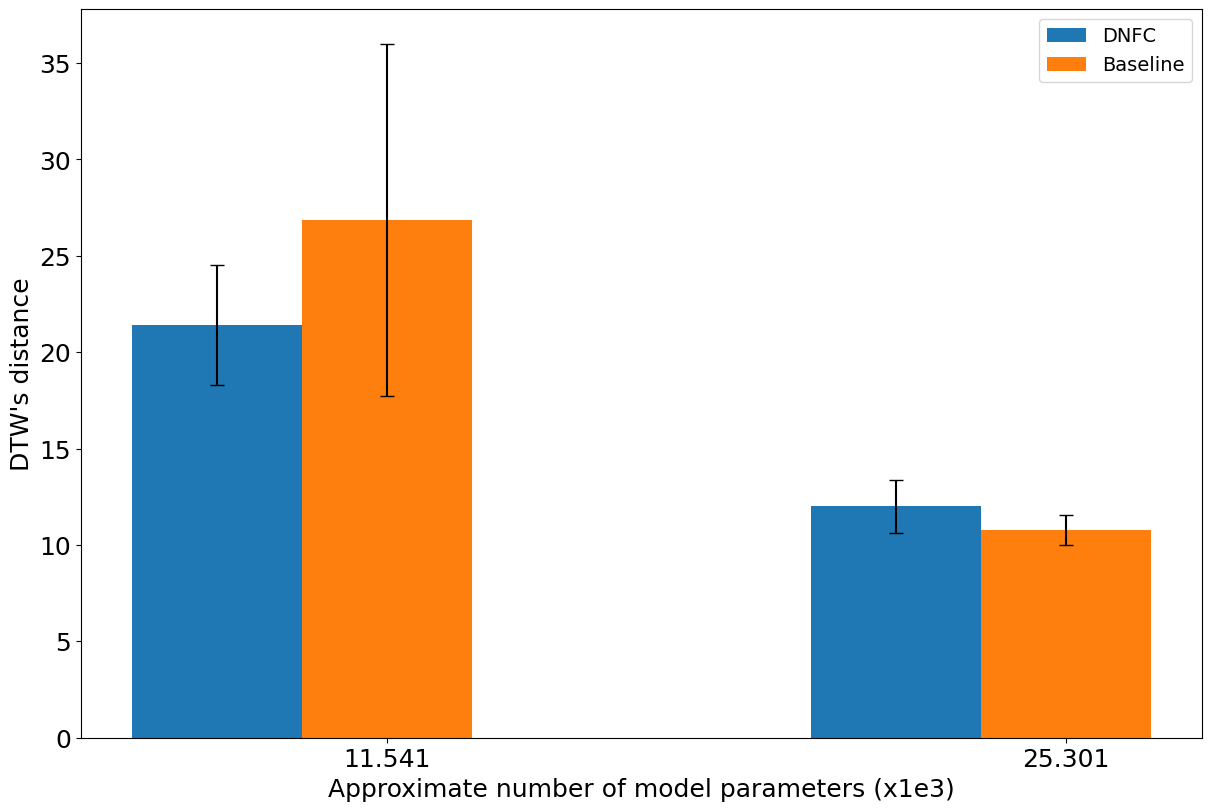

{'DNFC': [21.397430355473407, 11.998474478251426], 'Baseline': [26.860292738659506, 10.76664168863218]}
{'DNFC': [3.0998666897722167, 1.3588449640082523], 'Baseline': [9.124266158832638, 0.790827179373924]}


In [19]:
Ys = {
    'DNFC': [x for x in stats_model['dtw_mean']],
    'Baseline': [x for x in stats_base['dtw_mean']],
    # 'DNFC-ablation': [x for x in stats_abl['dtw_mean']],
}

errors = {
    'DNFC': [x for x in stats_model['dtw_std']],
    'Baseline': [x for x in stats_base['dtw_std']],
    # 'DNFC-ablation': [x for x in stats_abl['dtw_std']],
}

x = np.arange(len(model_params_list))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained', figsize=(12, 8))

for attribute, measurement in Ys.items():
    offset = width * multiplier
    # print(attribute)
    rects = ax.bar(x + offset, measurement, width, label=attribute, yerr=errors[attribute],
                   error_kw={'capsize': 5})
    # ax.bar_label(rects, fmt='%.2f', padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel("DTW's distance")
ax.set_xlabel("Approximate number of model parameters (x1e3)")
# ax.set_title('Robot Endpoint-Target Distance')
ax.set_xticks(x + width, model_params_list)
# ax.legend(loc='upper left', ncols=3)
ax.legend()
# ax.set_ylim(0, 250)
plt.savefig(os.path.join(os.getcwd(), "paper/dtw.png"))
plt.show()
print(Ys)
print(errors)

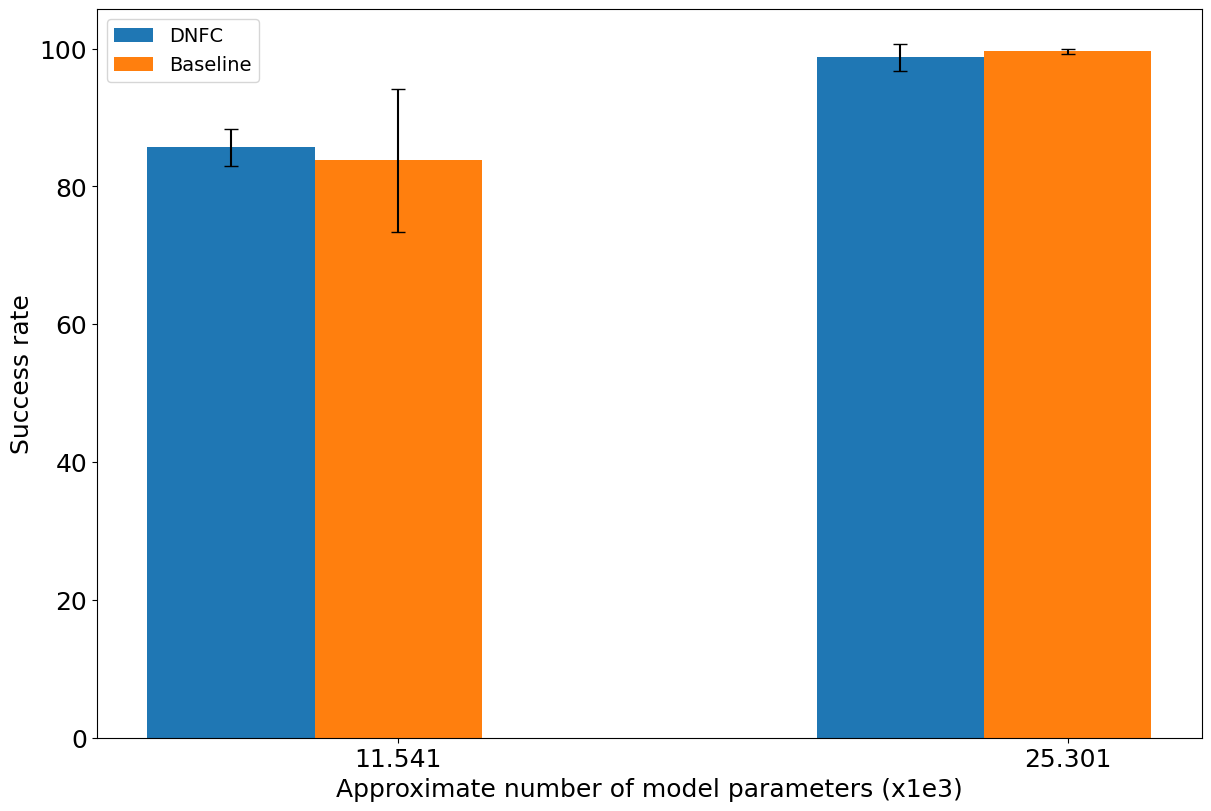

{'DNFC': [85.65, 98.7], 'Baseline': [83.8, 99.6]}
{'DNFC': [2.684445939109223, 1.9557607215607946], 'Baseline': [10.367316431941296, 0.37914377220257756]}


In [20]:
Ys = {
    'DNFC': [x for x in stats_model['succ_mean']],
    'Baseline': [x for x in stats_base['succ_mean']],
    # 'DNFC-ablation': [x for x in stats_abl['succ_mean']],
}

errors = {
    'DNFC': [x for x in stats_model['succ_std']],
    'Baseline': [x for x in stats_base['succ_std']],
    # 'DNFC-ablation': [x for x in stats_abl['succ_std']],
}

x = np.arange(len(model_params_list))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained', figsize=(12, 8))

for attribute, measurement in Ys.items():
    offset = width * multiplier
    # print(attribute)
    rects = ax.bar(x + offset, measurement, width, label=attribute, yerr=errors[attribute],
                   error_kw={'capsize': 5})
    # ax.bar_label(rects, fmt='%.2f', padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Success rate')
ax.set_xlabel("Approximate number of model parameters (x1e3)")
# ax.set_title('Robot Endpoint-Target Distance')
ax.set_xticks(x + width, model_params_list)
# ax.legend(loc='upper left', ncols=3)
ax.legend()
# ax.set_ylim(0, 250)
plt.savefig(os.path.join(os.getcwd(), "paper/succ.png"))
plt.show()
print(Ys)
print(errors)

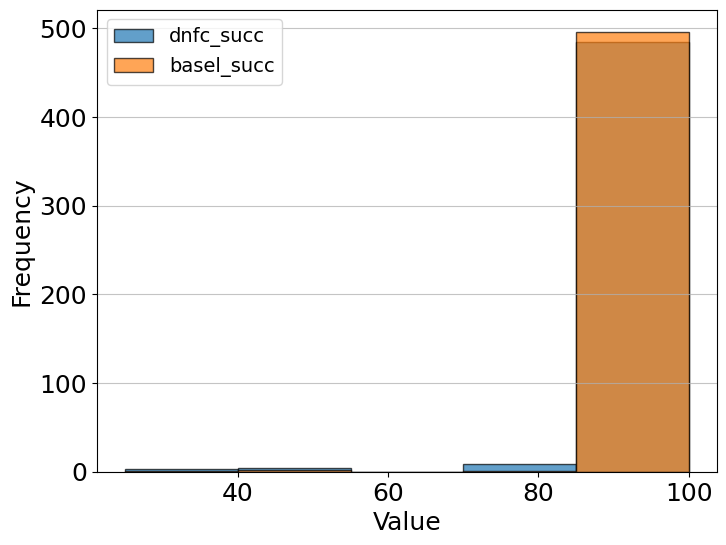

In [21]:
bin_no = 5

# Plot histograms for 'dnfc_succ' and 'basel_succ' side by side
plt.figure(figsize=(8, 6))
plt.hist(df["dnfc_succ"], bins=bin_no, alpha=0.7, label='dnfc_succ', edgecolor='black')
plt.hist(df["basel_succ"], bins=bin_no, alpha=0.7, label='basel_succ', edgecolor='black')
# plt.title("Histogram of dnfc_succ and basel_succ", fontsize=14)
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.legend()
plt.grid(axis='y', alpha=0.75)

file_path = os.path.join(root_dir, "succ_hist.png")
plt.savefig(file_path)
plt.show()

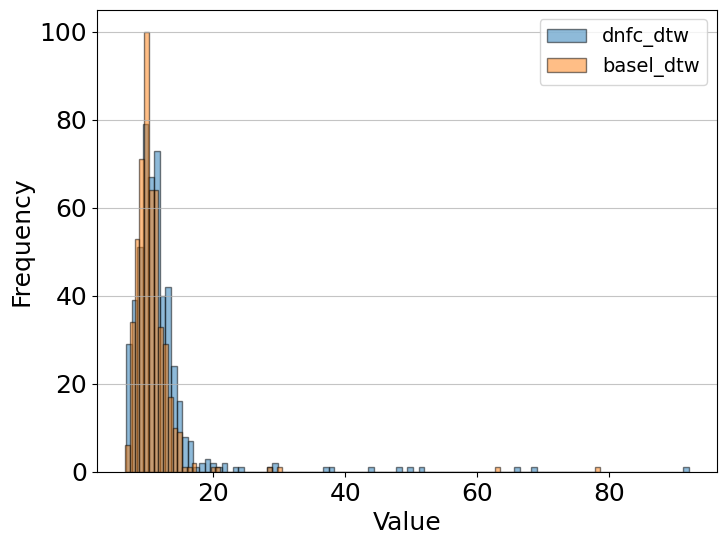

In [23]:
bin_no = 100

# Plot histograms for 'dnfc_succ' and 'basel_succ' side by side
plt.figure(figsize=(8, 6))
plt.hist(df["dnfc_dtw"], bins=bin_no, alpha=0.5, label='dnfc_dtw', edgecolor='black')
plt.hist(df["basel_dtw"], bins=bin_no, alpha=0.5, label='basel_dtw', edgecolor='black')
# plt.title("Histogram of dnfc_succ and basel_succ", fontsize=14)
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.legend()
plt.grid(axis='y', alpha=0.75)

file_path = os.path.join(root_dir, "dtw_hist.png")
plt.savefig(file_path)
plt.show()


In [2]:
root_dir = "/home/arash/catkin_ws/src/feedback_controller/fbc/neural_network/results/"
root_dir += "trajs:360_blocks:3_triangle_v_7.541K/ep:1000/on_v_custl_const_1e-05"

In [8]:
file_path = os.path.join(root_dir, "all_states_dnfc")
with open(file_path, 'rb') as f:
    all_states_dnfc = pickle.load(f)

In [ ]:
eps_no = 27

dnfc_data = all_states_dnfc[eps_no]

In [ ]:
joint_vals = [timestep_data[4] for timestep_data in dnfc_data]
timesteps = range(len(joint_vals))

plt.figure(figsize=(10, 6))
plt.plot(timesteps, joint_vals)
plt.xlabel("Timestep")
plt.ylabel("Value")
# plt.title("Fifth Value Across Timesteps")
# plt.legend()
plt.grid(True)
plt.show()

### Loss

In [2]:
root_dir = "/home/arash/catkin_ws/src/feedback_controller/fbc/neural_network/weights/"
root_dir += "trajs:360_blocks:3_triangle_v|0.8|cus_los_1e-05|tar_cart|v_custl_mse|7.541K_params/"

file_path = os.path.join(root_dir, "train_no_0/loss.csv")
df = pd.read_csv(file_path)  

In [ ]:
df.head()

In [ ]:
# Filter the dataframe for n >= 10
filtered_df = df[df["n"] >= 10]

# Plot train_loss_torques and val_loss_torques vs n
plt.figure(figsize=(8, 6))
plt.plot(filtered_df["n"], filtered_df["train_loss_torques"], marker='o', linestyle='-', label="Train Loss Torques")
plt.plot(filtered_df["n"], filtered_df["val_loss_torques"], marker='x', linestyle='-', label="Val Loss Torques")
plt.xlabel("n")
plt.ylabel("Loss")
plt.title("Train and Val Loss Torques vs n (n >= 10)")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
filtered_df

### Latent Representations

In [3]:
def get_file(model_dir, is_not_abl, file_name):
    file_dir = os.path.join(model_dir, f"on_v_custl_mse_1e-05_{is_not_abl}")
    file_path = os.path.join(file_dir, f"{file_name}")
    with open(file_path, 'rb') as f:
        latent_reps = pickle.load(f)
    return latent_reps

def get_csv(model_dir, is_not_abl):
    file_dir = os.path.join(model_dir, f"on_v_custl_mse_1e-05_{is_not_abl}")
    file_path = os.path.join(file_dir, "perf.csv")
    df = pd.read_csv(file_path)  
    return df

def add_train_round(df):
    df['train_round'] = df.groupby('eps_num').cumcount() + 1
    return df

In [4]:
def intrinsic_to_3d_cart(all_joints_vals):
    x, y, z = [], [], []
    for joints_vals in all_joints_vals:
        my_l = [0, 0]
        for j_val in joints_vals:
            my_l.append(float(j_val))
        p, R = kin.forwardkin(1, np.array(my_l))
        x.append(p[0])
        y.append(p[1])
        z.append(p[2])

    return x, y, z

In [7]:
def plot_latent_reps(latent_reps, latent_reps_abl, states, states_abl,
                     df_perf, df_perf_abl, i_eps, model_dir):
    # Transpose the data to separate each joint
    lat_rep_transp = list(zip(*latent_reps))
    lat_rep_abl_transp = list(zip(*latent_reps_abl))
    states_transp = list(zip(*states))
    states_abl_transp = list(zip(*states_abl))

    # print(len(lat_rep_transp), len(lat_rep_transp[0]))
    # Plot each joint's position over time
    time_steps = range(len(latent_reps))  # Assuming each inner list corresponds to a timestep
    
    colors = [
        'blue', 'green', 'red', 'cyan', 'magenta', #'yellow', 
        'black', 'orange', 'purple', 'brown', 'pink', 'lime', 
        'teal', 'gold'
    ]
    
    # Create a figure with 7 subplots arranged vertically
    fig, axes = plt.subplots(7, 1, figsize=(12, 14), sharex=True)
    fig.tight_layout(pad=0.0)  # Adjust spacing between subplots

    for idx, lat_rep in enumerate(lat_rep_transp[:7]):
        ax = axes[idx]  # Select the subplot corresponding to the current index
        if idx < 7: label_st = f'Jnt.{idx + 1}'
        else: label_st = f'Vel.{(idx%7) + 1}'

        # print(len(lat_rep), len(lat_rep_abl_transp), len(states_transp))
        ax.plot(time_steps, lat_rep, 
                 label=f'Dim{idx + 1}', color=colors[idx])
        ax.plot(time_steps, lat_rep_abl_transp[idx], 
                 label=f'Dim{idx + 1}a', color=colors[idx], linestyle='dashed')
        ax.plot(time_steps, states_transp[idx], 
                 label=label_st, color=colors[idx])#<, linestyle='dashed')
        ax.plot(time_steps, states_abl_transp[idx], 
                 label=f'Jnt.{idx + 1}a', color=colors[idx], linestyle='dotted')
        
        # Add labels and legend to each subplot
        ax.set_ylabel(f'Dim {idx + 1}')
        ax.legend()
        ax.grid(True)

    eps_no = i_eps // 5
    train_no = i_eps % 5
    # Add a common xlabel and adjust layout
    axes[-1].set_xlabel('Time Steps')
    fig.suptitle(f"DNFC: {df_perf['dnfc_succ']}, DNFC-abl: {df_perf_abl['dnfc_succ']}")
    # plt.show()
    plot_dir = os.path.join(model_dir, f'latent_reps')
    if os.path.exists(plot_dir):
        pass
        # print("Latent dir. already exists. Are you trying to generate it again?")
        # sys.exit(1)
    else:
        os.makedirs(plot_dir)
    plot_path = os.path.join(plot_dir, f"eps:{eps_no}_train:{train_no}.png")
    plt.savefig(plot_path)
    plt.close()

In [8]:
for num_params in model_params_list:
    model_dir = os.path.join(root_dir, f"trajs:360_blocks:3_triangle_v_{num_params}K/ep:1000/")
    latent_reps = get_file(model_dir, True, "all_latent_reps")
    latent_reps_abl = get_file(model_dir, False, "all_latent_reps")
    states_dnfc = get_file(model_dir, True, "all_states_dnfc")
    states_abl = get_file(model_dir, False, "all_states_dnfc")

    df_perf = get_csv(model_dir, True)
    df_perf = add_train_round(df_perf)
    df_perf_abl = get_csv(model_dir, False)
    df_perf_abl = add_train_round(df_perf_abl)
    # print(df_perf_abl.head(10))

    for i_eps in range(len(latent_reps)):
        plot_latent_reps(latent_reps[i_eps], 
                            latent_reps_abl[i_eps], 
                            states_dnfc[i_eps],
                            states_abl[i_eps], 
                            df_perf.loc[i_eps], df_perf_abl.loc[i_eps], i_eps, model_dir)